In [ ]:
from google.colab import drive
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
train_dir = "/content/drive/MyDrive/Us/train"
test_dir = "/content/drive/MyDrive/Us/val"

In [ ]:
model = VGG16(include_top=True, weights='imagenet')

In [ ]:
input_shape = model.layers[0].output_shape[0][1:3]
input_shape

(224, 224)

In [ ]:
datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

In [ ]:
datagen_test = ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size = 20

In [ ]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

Found 45646 images belonging to 2 classes.


In [ ]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 1194 images belonging to 2 classes.


In [ ]:
steps_test = generator_test.n / batch_size
steps_test

59.7

In [ ]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [ ]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

In [ ]:
cls_train = generator_train.classes
cls_test = generator_test.classes

In [ ]:
class_names = list(generator_train.class_indices.keys())
class_names

['0', '1']

In [ ]:
num_classes = generator_train.num_classes
num_classes

2

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
transfer_layer = model.get_layer('block5_pool')

In [ ]:
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [ ]:
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='sigmoid'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
new_model.add(Dense(num_classes, activation='sigmoid'))

In [ ]:
optimizer = Adam(lr=1e-5)
metrics = ['binary_accuracy']
loss = 'binary_crossentropy'


In [ ]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [ ]:
print_layer_trainable()

True:	input_2
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [ ]:
conv_model.trainable = False

In [ ]:
for layer in conv_model.layers:
    layer.trainable = False

In [ ]:
print_layer_trainable()

False:	input_2
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [ ]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
epochs = 25
steps_per_epoch = 100

In [ ]:
history = new_model.fit(x=generator_train,
                        epochs=epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=generator_test,
                        validation_steps=steps_test)

Epoch 1/25
100/100 [==============================] - 681s 7s/step - loss: 0.7306 - binary_accuracy: 0.5085 - val_loss: 0.6922 - val_binary_accuracy: 0.5318
Epoch 2/25
100/100 [==============================] - 651s 7s/step - loss: 0.7210 - binary_accuracy: 0.5130 - val_loss: 0.6951 - val_binary_accuracy: 0.5243
Epoch 3/25
100/100 [==============================] - 618s 6s/step - loss: 0.7192 - binary_accuracy: 0.5088 - val_loss: 0.6910 - val_binary_accuracy: 0.5431
Epoch 4/25
100/100 [==============================] - 598s 6s/step - loss: 0.7148 - binary_accuracy: 0.5263 - val_loss: 0.6906 - val_binary_accuracy: 0.5427
Epoch 5/25
100/100 [==============================] - 564s 6s/step - loss: 0.7161 - binary_accuracy: 0.5170 - val_loss: 0.6930 - val_binary_accuracy: 0.5218
Epoch 6/25
100/100 [==============================] - 548s 5s/step - loss: 0.7175 - binary_accuracy: 0.4955 - val_loss: 0.6997 - val_binary_accuracy: 0.5029
Epoch 7/25
100/100 [==============================] - 514s

In [ ]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['binary_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_binary_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

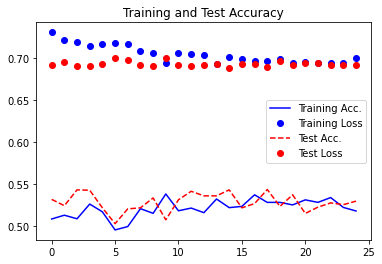

In [ ]:
plot_training_history(history)

In [ ]:
#Fine tunning
conv_model.trainable = True

In [ ]:
for layer in conv_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

In [ ]:
optimizer_fine = Adam(lr=1e-7)

In [ ]:
new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

In [ ]:
history = new_model.fit(x=generator_train,
                        epochs=epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=generator_test,
                        validation_steps=steps_test)

Epoch 1/25
100/100 [==============================] - 267s 3s/step - loss: 0.6930 - binary_accuracy: 0.5300 - val_loss: 0.6914 - val_binary_accuracy: 0.5302
Epoch 2/25
100/100 [==============================] - 256s 3s/step - loss: 0.6910 - binary_accuracy: 0.5325 - val_loss: 0.6911 - val_binary_accuracy: 0.5369
Epoch 3/25
100/100 [==============================] - 244s 2s/step - loss: 0.6864 - binary_accuracy: 0.5430 - val_loss: 0.6911 - val_binary_accuracy: 0.5343
Epoch 4/25
100/100 [==============================] - 228s 2s/step - loss: 0.6922 - binary_accuracy: 0.5180 - val_loss: 0.6910 - val_binary_accuracy: 0.5373
Epoch 5/25
100/100 [==============================] - 247s 2s/step - loss: 0.6905 - binary_accuracy: 0.5305 - val_loss: 0.6910 - val_binary_accuracy: 0.5360
Epoch 6/25
100/100 [==============================] - 229s 2s/step - loss: 0.6936 - binary_accuracy: 0.5222 - val_loss: 0.6909 - val_binary_accuracy: 0.5381
Epoch 7/25
100/100 [==============================] - 215s